In [1]:
from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv
from baselines.common.vec_env.dummy_vec_env import DummyVecEnv
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import copy
import random
import gym

%matplotlib inline

In [2]:
# Moving average
def smoothen_curve(points, factor=0):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


def plot(array, title='', axis=plt):
    axis.title.set_text(title)
    axis.plot(np.arange(len(array)), smoothen_curve(array))

In [3]:
def make_env(env_id, seed):
    def _f():
        env = gym.make(env_id)
        env.seed(seed)

        # Desync environments
        env.reset()
        for i in range(int(env.spec.max_episode_steps*seed//nproc)):
            env.step(env.action_space.sample())
        return env
    return _f

In [4]:
env_name = "MountainCar-v0"
stochastic_action_likelihood = 0.9
discount = 0.99
state_queue_size = 1
learning_rate = 0.1

iterations = 1000
batch_size = 64
update_net_period = 50
history_size = 500

nproc = 30
envs = DummyVecEnv([make_env(env_name, seed) for seed in range(nproc)]) #Dummy
        
# This code gets action and observation space sizes for 1D tasks
action_space_size = envs.action_space.n if isinstance(envs.action_space, gym.spaces.discrete.Discrete) else envs.action_space.shape[0]
observation_space_size = envs.observation_space.n if isinstance(envs.observation_space, gym.spaces.discrete.Discrete) else envs.observation_space.shape[0]

plots_data = {
    "reward": [],
    "loss": [],
    "gradients_max_abs": [],
    "gradients_equal_zero": [],
    "max_action": [],
    "max_qvals": [],
    "min_qvals": [],
}

In [5]:
tf.reset_default_graph()
sess = tf.Session()

class QualityNet:
    def __init__(self, net_name, copy_from_net):
        with tf.variable_scope(net_name + "/"):
            layers_config = (action_space_size + state_queue_size*observation_space_size, 256) # 32 - hidden layer size

            self.input_state = tf.placeholder(tf.float32, shape=[None, state_queue_size, observation_space_size], name="input_state")
            self.flattened_state = tf.reshape(self.input_state, [-1, observation_space_size * state_queue_size])
            self.input_action = tf.placeholder(tf.int32, shape=[None], name="input_action")
            input_action_one_hot = tf.one_hot(self.input_action, depth=action_space_size)
            
            self.input_data = tf.concat([self.flattened_state, input_action_one_hot], 1)
            
            self.input_layer = tf.layers.dense(self.input_data, units=256, activation='sigmoid')
            self.hidden_layer = tf.layers.dense(self.input_layer, units=layers_config[1], activation='sigmoid')
            self.output_layer = tf.layers.dense(self.hidden_layer, units=1)
            
            self.exp_value = tf.placeholder(tf.float32, name="exp_value")
            self.loss = tf.losses.mean_squared_error(self.exp_value, self.output_layer)
            
            self.gradients = tf.gradients(self.loss, [t_var for t_var in tf.trainable_variables() if "train_net/" in t_var.name]) # For Debug!
            
            optimizer = tf.train.AdamOptimizer(learning_rate)
            self.train_op = optimizer.minimize(self.loss)
            
            if copy_from_net != None:
                self.vars_to_train = list()
                
                for var1 in tf.trainable_variables():
                    if net_name+"/" in var1.name:
                        for var2 in tf.trainable_variables():
                            if var2.op.name in str.replace(var1.name, net_name+"/", copy_from_net+"/"):
                                self.vars_to_train.append(var1)
                
                self.trained_vals = [tf.placeholder(tf.float32) for _ in range(len(self.vars_to_train))]
                self.copy_op = [tf.assign(self.vars_to_train[i], self.trained_vals[i]) for i in range(len(self.vars_to_train))]

train_net = QualityNet("train_net", None)    
prediction_net = QualityNet("prediction_net", "train_net")

sess.run(tf.local_variables_initializer())
sess.run(tf.global_variables_initializer())

W0717 22:20:27.198088 10076 deprecation.py:323] From <ipython-input-5-98fcc4048606>:16: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0717 22:20:27.202044 10076 deprecation.py:506] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0717 22:20:27.453405 10076 deprecation.py:323] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\losses\losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
def prepare_input(states_q):
    return np.repeat(np.array(states_q), repeats=action_space_size, axis=0), np.tile(range(action_space_size), len(states_q))

In [7]:
def normalize_data(observations, rewards, dones, info):
    minX, maxX = -1.25, 0.5
    minV, maxV = -0.06, 0.06
    
    for i in range(len(observations)):
        observations[i][0] = ((observations[i][0] - minX) / (maxX - minX)) * 10 - 5
        observations[i][1] = ((observations[i][1] - minV) / (maxV - minV)) * 10 - 5
    rewards = rewards / 50
    return observations, rewards, dones, info

normalize_data([[0.5, -0.06]], -1, False, "Sdf")

([[5.0, -5.0]], -0.02, False, 'Sdf')

In [8]:
def update_state(state_queue, val):
    state_queue.pop()
    state_queue.insert(0, val)

def batch_generator(batch_size, history_size):
    """
        history[0] = queue of four last states
        history[1] = action
        history[2] = reward
        history[3] = states queue with new state
        history[4] = discounted reward
    """
    states_q = [[np.random.sample(observation_space_size) for _ in range(state_queue_size)] for _ in range(nproc)]
    trajectories = [np.empty((0, 4)) for _ in range(nproc)]
    
    history = np.empty((0, 5))
    observations = [[0 for i in range(observation_space_size)] for j in range(nproc)] #envs.reset()
    for pid in range(nproc):
        update_state(states_q[pid], observations[pid])

    while True:
        history = history[batch_size:]
        while len(history) < history_size:
            if random.random() < stochastic_action_likelihood:
                actions = np.stack([envs.action_space.sample() for _ in range(nproc)])
            else:
                ############ action prediction ############
                input_states, input_actions = prepare_input(states_q)
                qvalues = sess.run((train_net.output_layer), feed_dict={
                        train_net.input_state: input_states,
                        train_net.input_action: input_actions,
                    })
                qvalues = qvalues.reshape(len(qvalues) // action_space_size, action_space_size)
                plots_data["max_qvals"].append(qvalues.max(axis=1)[0])
                plots_data["min_qvals"].append(qvalues.min(axis=1)[0])
                actions = np.argmax(qvalues, axis=1)
                ###########################################
            observations, rewards, dones, _ = normalize_data(*envs.step(actions))

            for pid in range(nproc):
                old_state = copy.deepcopy(states_q[pid])
                update_state(states_q[pid], observations[pid])
                
                trajectories[pid] = np.vstack((trajectories[pid], [old_state, actions[pid], rewards[pid], states_q[pid]]))

                if dones[pid]:
                    ################ qvalues prediction ################
                    input_states, input_actions = prepare_input(trajectories[pid][:-1][:, 3])
                    qvalues = sess.run((train_net.output_layer), feed_dict={
                            train_net.input_state: np.array(input_states.tolist()),
                            train_net.input_action: input_actions,
                        })
                    qvalues = qvalues.reshape(len(qvalues) // action_space_size, action_space_size).max(axis=1)
                    qvalues *= discount
                    qvalues = qvalues + trajectories[pid][:-1, 2]
                    qvalues = np.append(qvalues, rewards[pid])
                    ####################################################

                    new_history = np.hstack((trajectories[pid], np.expand_dims(qvalues, axis=-1)))   
                    plots_data["reward"].append(trajectories[pid][:-1][:, 2].sum() + rewards[pid])
                    trajectories[pid] = np.empty((0, 4))
                    history = np.vstack((history, new_history))

        np.random.shuffle(history)
        history = history[:history_size]
        yield history[:batch_size]

In [12]:
batch_gen = batch_generator(batch_size, history_size)

for i in range(10):
    next(batch_gen)

for i in tqdm_notebook(range(iterations)):
    batch = next(batch_gen)

    ################ Training net ##################
    input_state = np.array(batch[:, 0].tolist())
    input_action = batch[:, 1]
    _, loss, gradients = sess.run((train_net.train_op, train_net.loss, train_net.gradients), 
                       feed_dict = {
                            train_net.input_state: input_state,
                            train_net.input_action: input_action,
                            train_net.exp_value: batch[:, 4],
                        })
    #print(batch[:, 4].mean(), batch[:, 4].std())
    ################################################

    #****************** DEBUG ******************* 
    plots_data["loss"].append(loss)
    plots_data["gradients_max_abs"].append(np.max([np.max(np.abs(var_grad)) for var_grad in gradients]))
    plots_data["gradients_equal_zero"].append(len(gradients[gradients == 0]))
    #*********************************************

#     if (i+1) % update_net_period == 0 or i == iterations - 1:
#         variables = tf.trainable_variables()
#         trained_vars = list()

#         for var1 in variables:
#             if "train_net/" in var1.name:
#                 trained_vars.append([var2 for var2 in tf.trainable_variables() if var2.op.name in str.replace(var1.name, "prediction_net/", "train_net/")][0])
        
#         trained_vals = sess.run((trained_vars))
#         sess.run((prediction_net.copy_op), feed_dict={
#             prediction_net.trained_vals[i]: trained_vals[i] for i in range(len(prediction_net.trained_vals))
#         })


    
    # Make
    d = 30
    b = 0
    x = np.linspace(envs.observation_space.low[0] - b, envs.observation_space.high[0] + b, num=d)
    y = np.linspace(envs.observation_space.low[1] - b, envs.observation_space.high[1] + b, num=d)

#     print(list(map(norm_x, x)))
#     print(list(map(norm_v, y)))

#     qvalues = np.zeros((len(x), len(y)))
#     for i in range(len(x)):
#         for j in range(len(y)):
#             qvalues[i][j] = sess.run((train_net.output_layer), feed_dict={
#                 train_net.input_state: [[[x[i], y[j]]], [[x[i], y[j]]], [[x[i], y[j]]]],
#                 train_net.input_action: [0, 1, 2],
#             })[0][0]
#     if qvalues.std() == 0:
#         print('dead')

    print(stochastic_action_likelihood)
    stochastic_action_likelihood -= (0.9 - 0.1) / iterations

0.7727999999999964
0.7719999999999964
0.7711999999999963
0.7703999999999963
0.7695999999999963
0.7687999999999963
0.7679999999999962
0.7671999999999962
0.7663999999999962
0.7655999999999962
0.7647999999999961
0.7639999999999961
0.7631999999999961
0.7623999999999961
0.7615999999999961
0.760799999999996
0.759999999999996
0.759199999999996
0.758399999999996
0.7575999999999959
0.7567999999999959
0.7559999999999959
0.7551999999999959
0.7543999999999959
0.7535999999999958
0.7527999999999958
0.7519999999999958
0.7511999999999958
0.7503999999999957
0.7495999999999957
0.7487999999999957
0.7479999999999957
0.7471999999999956
0.7463999999999956
0.7455999999999956
0.7447999999999956
0.7439999999999956
0.7431999999999955
0.7423999999999955
0.7415999999999955
0.7407999999999955
0.7399999999999954
0.7391999999999954
0.7383999999999954
0.7375999999999954
0.7367999999999953
0.7359999999999953
0.7351999999999953
0.7343999999999953
0.7335999999999953
0.7327999999999952
0.7319999999999952
0.73119999999999

KeyboardInterrupt: 

In [13]:
stochastic_action_likelihood

0.42639999999998646

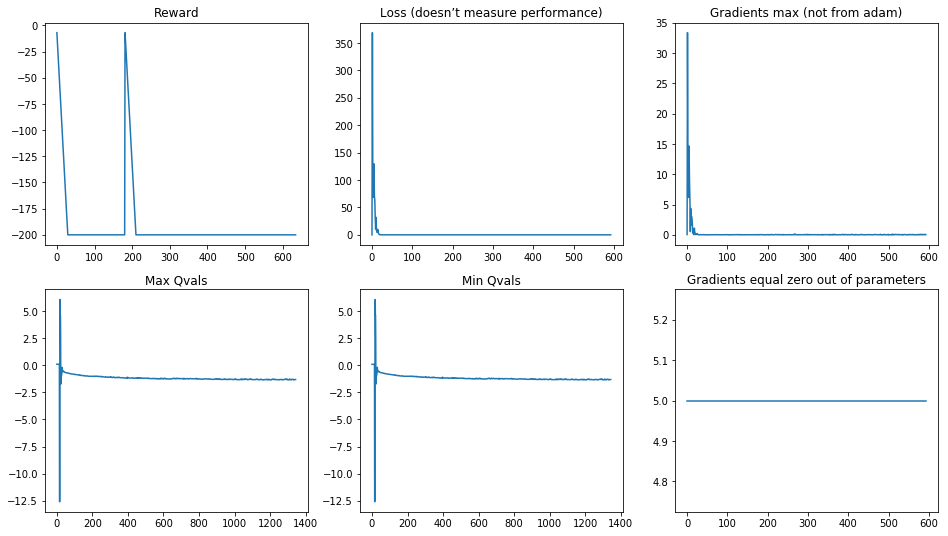

In [14]:
#************ Plotting debug info ****************
fig, axs = plt.subplots(2, 3, figsize=(16, 9))
plot(np.array(plots_data["reward"]) * 50, "Reward", axs[0, 0])
plot(plots_data["loss"], "Loss (doesn’t measure performance)", axs[0, 1])
plot(plots_data["max_qvals"], "Max Qvals", axs[1, 0])
plot(plots_data["min_qvals"], "Min Qvals", axs[1, 1])
plot(plots_data["gradients_max_abs"], "Gradients max (not from adam)", axs[0, 2])
plot(plots_data["gradients_equal_zero"], f"Gradients equal zero out of parameters", axs[1, 2])
plt.savefig('dqn-plots.png')
#*************************************************

Почему Q == 0

почему лосс == 0

Почему даже у необученной сетки она выдаёт равные результаты для разных акшенов

In [11]:
minX, maxX = -1.25, 0.5
minV, maxV = -0.06, 0.06

def norm_x(x):
    return ((x - minX) / (maxX - minX)) * 10 - 5
def norm_v(x):
    return ((x - minV) / (maxV - minV)) * 10 - 5

input_states = [[[norm_x(-0.5), norm_v(-0.02)]],[[norm_x(-0.5), norm_v(-0.02)]], [[norm_x(-0.5), norm_v(-0.02)]],
                [[norm_x(-0.3), norm_v(-0.02)]],[[norm_x(-0.3), norm_v(-0.02)]], [[norm_x(-0.3), norm_v(-0.02)]]]
input_actions = [0, 1, 2, 0, 1, 2]
qvalues = [0, 0, 0, 1, 1, 1]

for i in range(0):
    _, loss, gradients, input_data = sess.run((train_net.train_op, train_net.loss, train_net.gradients, train_net.input_data), 
           feed_dict = {
                train_net.input_state: input_states,
                train_net.input_action: input_actions,
                train_net.exp_value: qvalues,
            })
#print(input_data)

# variables = tf.trainable_variables()
# trained_vars = list()

# for var1 in variables:
#     if "train_net/" in var1.name:
#         trained_vars.append([var2 for var2 in tf.trainable_variables() if var2.op.name in str.replace(var1.name, "prediction_net/", "train_net/")][0])

# trained_vals = sess.run((trained_vars))
# _ = sess.run((prediction_net.copy_op), feed_dict={
#     prediction_net.trained_vals[i]: trained_vals[i] for i in range(len(prediction_net.trained_vals))
# })

In [ ]:
envs.observation_space.high[0]

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
%matplotlib notebook

fig = plt.figure(figsize=(12, 7))
ax = fig.gca(projection='3d')

# Make 
d = 30
b = 0
x = np.linspace(envs.observation_space.low[0] - b, envs.observation_space.high[0] + b, num=d)
y = np.linspace(envs.observation_space.low[1] - b, envs.observation_space.high[1] + b, num=d)

print(list(map(norm_x, x)))
print(list(map(norm_v, y)))

qvalues = np.zeros((len(x), len(y)))
for i in range(len(x)):
    for j in range(len(y)):
        qvalues[i][j] = sess.run((train_net.output_layer), feed_dict={
            train_net.input_state: [[[x[i], y[j]]], [[x[i], y[j]]], [[x[i], y[j]]]],
            train_net.input_action: [0, 1, 2],
        })[0][0]

# Make data.
X, Y = np.meshgrid(x, y)

# Plot the surface.
surf = ax.plot_surface(X, Y, qvalues, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlabel('X position', fontsize=10)
ax.set_ylabel('Velocity', fontsize=10)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

In [ ]:
qvalues.std()

In [ ]:
list(zip([(i.mean(), i.std(), i) for i in sess.run(tf.trainable_variables())], [i.name for i in tf.trainable_variables()] ))


In [ ]:
sess.run((train_net.output_layer), feed_dict={
            train_net.input_state: [[[x[i], y[j]]], [[x[i], y[j]]], [[x[i], y[j]]]],
            train_net.input_action: [0, 1, 2],
        })#[0]#[0]

(1080, 1920, 3)


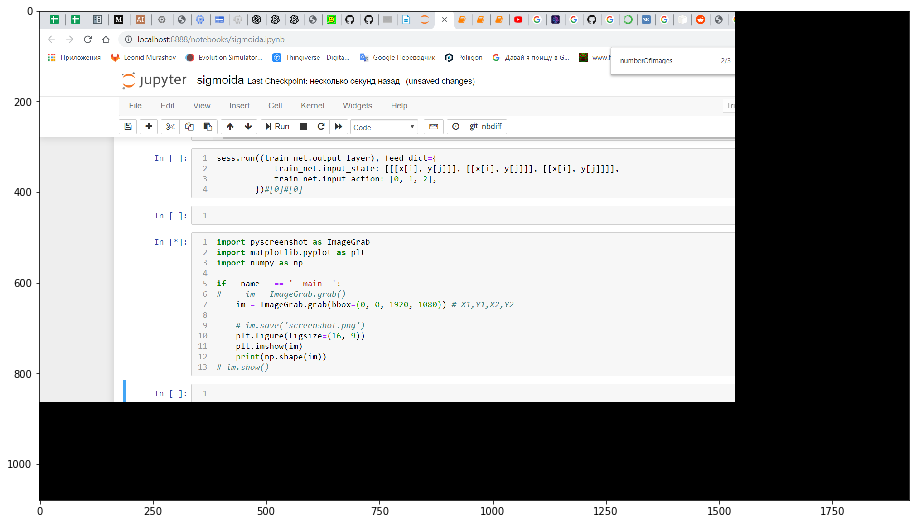

In [19]:
import pyscreenshot as ImageGrab
import matplotlib.pyplot as plt
import numpy as np

if __name__ == '__main__':
#     im = ImageGrab.grab()
    im = ImageGrab.grab(bbox=(0, 0, 1920, 1080)) # X1,Y1,X2,Y2

    # im.save('screenshot.png')
    plt.figure(figsize=(16, 9))
    plt.imshow(im)
    print(np.shape(im))
# im.show()

In [21]:
2**33/(5*1000*300)

5726.623061333334